In [6]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix


In [7]:
torch.cuda.empty_cache()

In [8]:
# pip install git+https://github.com/facebookresearch/segment-anything.git

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

sam_predictor = SamPredictor(sam)

In [9]:
def read_imag(file_path):
    name_img = os.path.basename(file_path)
    name_img, ext = os.path.splitext(name_img)
    print(name_img)
    if os.path.exists(file_path):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #image1 =cv2.resize(img, (size_resize,size_resize))
      #  image11 = 255 * (image1 - image1.min()) / (image1.max() - image1.min())
    else:
        print("File not found:", file_path)
    return img,name_img

In [10]:
def Gamma_Correction (image, gamma):

    gamma_corrected_image = np.power(image / 255.0, gamma) * 255.0
    image_GC = np.uint8(gamma_corrected_image) #gamma_corrected image
    return image_GC

In [11]:
#rescale_intensity
from skimage import exposure, img_as_float
from skimage.util import compare_images

def preprocessing(image):
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2,p98)) # Contrast stretching
    #print(image1.mean() > img_rescale.mean()) # Output is darker for gamma > 1
    #equalize_hist
    img_equalized = exposure.equalize_hist(image)
    img_equalized = (img_equalized* 255).astype('uint8')
    # Gaussian Blur is used to remove the random noise in the image pixel. kernel size=(7,7), and standard deviation = 0
    imag_BlurGaussian = cv2.GaussianBlur(image, (7, 7), 0) 
    #comp_equalized = compare_images(image1, img1_equalized, method='checkerboard')
    return img_rescale, img_equalized,imag_BlurGaussian

def plot_image_preproc(imag,img_rescale,img_equalized,img_BlurGaussian, name_img):
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(15, 10))
    ax1.imshow(imag)
    ax1.set_title('Raw image')
    ax1.set_ylabel('{}'.format(name_img))
    ax2.imshow(img_rescale)
    ax2.set_title('Contrast stretching')
    ax3.imshow(img_equalized)
    ax3.set_title('Equalized hist')
    ax4.imshow(img_BlurGaussian)
    ax4.set_title('Gaussian Blur')
    plt.show()

In [12]:
##Generate Masks

In [13]:
#Evalute Masks
def select_segment(masks):
    #print("the area of bigest segment is:", max(region['area'] for region in masks))
    #print("the area of smallest segment is", min(region['area'] for region in masks))
    mean_areas = np.mean([region['area'] for region in masks])
    median_areas = np.median([region['area'] for region in masks])
  #  print("the mean value of segmented area is", mean_areas)
  #  print("the median value of segmented area is", median_areas)

    upper_quartile = np.percentile([region['area'] for region in masks], 75)
    lower_quartile = np.percentile([region['area'] for region in masks], 25)
    iqr = upper_quartile - lower_quartile
    thr_boxplot_u = upper_quartile +3*iqr
    thr_boxplot_d = lower_quartile -3*iqr
   # print("the upper threshold by boxplot:", thr_boxplot_u)
   # print("the lower threshold by boxplot:", thr_boxplot_d)

    threshold1= median_areas
    threshold2= mean_areas
    selected_segments_m = [region for region in masks if ((region['area'] > threshold1) & (region['area'] < threshold2))]
   # print("length of selected segments by M1 is:", len(selected_segments_m))

    selected_segments_b = [region for region in masks if ((region['area'] > thr_boxplot_d) & (region['area'] < thr_boxplot_u))]
   # print("length of selected segments by M2 is:", len(selected_segments_b))
    return selected_segments_m, selected_segments_b

def plot_selec_seg(img,selected_segments,selected_segments_b,name_img):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))
    ax1.imshow(img)
    show_anns(selected_segments,ax1)
    ax1.set_title('Image {}'.format(name_img)+ 'with selected segmented areas m1', fontsize=10)
    ax2.imshow(img)
    plot_bb(selected_segments,ax2)
    ax2.set_title('Image {}'.format(name_img)+ 'with selected Bounding Boxes m1', fontsize=10)
    ax3.imshow(img)
    show_anns(selected_segments_b,ax3)
    ax3.set_title('Image {}'.format(name_img)+ 'with selected segmented areas m2', fontsize=10)
    ax4.imshow(img)
    plot_bb(selected_segments_b,ax4)
    ax4.set_title('Image {}'.format(name_img)+ 'with selected Bounding Boxes m2', fontsize=10)
    plt.show()

In [14]:
#change detection

In [15]:
def calculate_iou_bb(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    width_inter = max(0, xB - xA)
    height_inter = max(0, yB - yA)
    area_inter = width_inter * height_inter
    area_A = boxA[2] * boxA[3]
    area_B = boxB[2] * boxB[3]
    area_union = area_A + area_B - area_inter
    iou = area_inter / max(area_union, 1e-10)  # To avoid division by zero
    return iou

In [16]:
def match_objects_bb(segments1, segments2, iou_threshold):
    matches = []
    mached_seg1 =[]
    mached_seg2 = []
    unmatch_seg1=[]
    
    for idx1, seg1 in enumerate(segments1):
        bbox1 = seg1['bbox']

        best_match = None
        best_iou = 0.0

        for idx2, seg2 in enumerate(segments2):
            #print(len(segments2))
            bbox2 = seg2['bbox']
            iou = calculate_iou_bb(bbox1, bbox2)
           # print(iou)
            if iou > best_iou:
                best_iou = iou
                best_match = idx2
                seg_match = seg2
        if best_iou >= iou_threshold:
            #print(best_iou)
            matches.append((idx1, best_match))
            mached_seg2.append(seg_match)
            mached_seg1.append(seg1)
           # del segments2[best_match]
        else:
            unmatch_seg1.append(seg1)
          

    return matches,mached_seg1,mached_seg2,unmatch_seg1


In [17]:
def show_anns2(anns, ax): #,name_img
    if len(anns) == 0:
        return
   # np.random.seed(random_seed)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
   # print(len(sorted_anns))
   # ax = plt.gca()
    #ax.set_autoscale_on(False)
    color_cover =[255, 255, 0]
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    print(img.shape)
    img[:,:,3] = 0
    for ann in anns:
        m = ann['segmentation']
        m = np.array(m, dtype=bool)
        color_mask = np.concatenate([color_cover, [.5]])
        img[m] = color_mask
    ax.imshow(img)

In [18]:
def calculate_metrics(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TN = confusion_matrix[0, 0]
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate specificity (True Negative Rate)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    # Calculate False Positive Rate (FPR)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

    return accuracy, precision, recall, f1_score, specificity, fpr

In [19]:
def compute_IOU_CM(GT,predicted):
    ## GT and predicted should be binary
    '''
    # Binarize images
    _, ground_truth_bin = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)
    _, predicted_bin = cv2.threshold(predicted, 127, 255, cv2.THRESH_BINARY)

    # Convert 255 to 1 for IoU computation
    ground_truth_bin = ground_truth_bin // 255
    predicted_bin = predicted_bin // 255
    '''
    intersection = np.logical_and(GT, predicted)
    union = np.logical_or(GT, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    print(f"IoU Score: {iou_score}")


In [29]:
file_path_A = '/home/dock/project_CD_jupyter/my_project_env/Meta_repository/test_DSIFN/t1/'
file_path_B = '/home/dock/project_CD_jupyter/my_project_env/Meta_repository/test_DSIFN/t2/'
GroundT_path = '/home/dock/project_CD_jupyter/my_project_env/Meta_repository/test_DSIFN/mask/'
iou_scores =[]
accuracy =[]
precision =[]
recall =[]
F1_score =[]
specificity =[]
Fpr =[]


for filename in os.listdir(file_path_A):
    img_path_A = os.path.join(file_path_A, filename)
    img_path_B = os.path.join(file_path_B, filename)
   
    name_im = os.path.basename(img_path_A)
    name_im, ext = os.path.splitext(name_im)
    GT_path = os.path.join(GroundT_path, name_im +'.tif')

    imageA,name_img = read_imag(img_path_A)
    imageB,name_img = read_imag(img_path_B)

    #Gamma Correction:
    imageA_GC = Gamma_Correction (imageA, gamma=0.8)
    imageB_GC = Gamma_Correction (imageB, gamma=1)

    #rescale_intensity
    imgA_rescale, imgA_equalized,imgA_BlurGaussian = preprocessing(imageA)
   #plot_image_preproc(imageA,imgA_rescale,imgA_equalized,imgA_BlurGaussian,name_img)

    imgB_rescale, imgB_equalized,imgB_BlurGaussian = preprocessing(imageB)
    #plot_image_preproc(imageB,imgB_rescale,imgB_equalized,imgB_BlurGaussian,name_img)

    masksA = mask_generator.generate((imageA).astype(np.uint8))
    masksB = mask_generator.generate((imageB).astype(np.uint8))


    ## Generate masks for equalized  and blured and Gamma corrected image
    masksA_rescaled = mask_generator.generate(imgA_rescale.astype(np.uint8))
    masksA_equalized = mask_generator.generate(imgA_equalized.astype(np.uint8))
    masksA_blur = mask_generator.generate(imgA_BlurGaussian.astype(np.uint8))
    masksA_GC = mask_generator.generate(imageA_GC)
    print("the number of segments for image1:",len(masksA))
    print("the number of segments for rescaled image1:",len(masksA_rescaled))
    print("the number of segments for equalized image1:", len(masksA_equalized))
    print("the number of segments for blured image1:", len(masksA_blur))
    print("the number of segments for Gamma corrected image1:", len(masksA_GC))
    print("*"*20)

    masksB_rescaled = mask_generator.generate(imgB_rescale.astype(np.uint8))
    masksB_equalized = mask_generator.generate(imgB_equalized.astype(np.uint8))
    masksB_blur = mask_generator.generate(imgB_BlurGaussian.astype(np.uint8))
    masksB_GC = mask_generator.generate(imageB_GC)
    print("the number of segments for image2:",len(masksB))
    print("the number of segments for rescaled image2:",len(masksB_rescaled))
    print("the number of segments for equalized image2:", len(masksB_equalized))
    print("the number of segments for blured image2:", len(masksB_blur))
    print("the number of segments for Gamma corrected image2:", len(masksB_GC))
    print("*"*20)

    sele_seg_m_A, sele_seg_b_A = select_segment(masksA) #masks1_blur #masks1_equalized
    #plot_selec_seg(imageA_GC, sele_seg_m_A,sele_seg_b_A,name_img)

    sele_seg_m_B, sele_seg_b_B = select_segment(masksB) #masks2_GC #masks2_equalized
    #plot_selec_seg(imageB, sele_seg_m_B,sele_seg_b_B,name_img)

    print("the number of segments for image1 after thresholding #1:",len(sele_seg_m_A))
    print("the number of segments for image1 after thresholding #2:",len(sele_seg_b_A))

    print("the number of segments for image2 after thresholding #1:",len(sele_seg_m_B))
    print("the number of segments for image2 after thresholding #2:",len(sele_seg_b_B))

    #change detection
    masks_ref = sorted(sele_seg_m_A, key=(lambda x: x['area']), reverse=True) #sele_seg_b_1 #sele_seg_m_1
    image_ref = imageA 
    name_img_ref = name_img
    print("length of reference mask is:", len(masks_ref))

    masks_eval_1 = sorted(sele_seg_m_B, key=(lambda x: x['area']), reverse=True) #sele_seg_b_2 #sele_seg_m_2
    image_eval_1 = imageB
    name_img_eval_1 = name_img
    print("length of mask under evalurion 1 is:", len(masks_eval_1))

    matches_1,mached_bb_ref_1,mached_bb_eval_1,unmatch_bb_ref_1 = match_objects_bb(masks_ref,masks_eval_1, iou_threshold=0.6)
    match_idx_ref_1 = [pair[0] for pair in matches_1]
    match_idx_eval_1 = [pair[1] for pair in matches_1]
    match_idx_eval_1 = sorted(list(set(match_idx_eval_1)))
    unmatch_bb_eval_1 = list(filter(lambda pair2: pair2[0] not in match_idx_eval_1, enumerate(masks_eval_1)))
    unmatch_bb_eval_1 = [segmen2 for index2, segmen2 in unmatch_bb_eval_1]

    unmatch_seg = np.any(np.array([xx['segmentation'] for xx in unmatch_bb_eval_1]),axis=0)

    ##Ground truth
    GT = cv2.imread(GT_path, cv2.IMREAD_UNCHANGED)
    #plt.imshow(GT)
    print(np.shape(GT))
    
   # iou = compute_IOU_CM(np.any(GT, axis=2).flatten(), unmatch_seg.flatten())
    iou = compute_IOU_CM(GT.flatten(), unmatch_seg.flatten())
    iou_scores.append(iou)
    #cm = confusion_matrix(np.any(GT, axis=2).flatten(), unmatch_seg.flatten()) 
    cm = confusion_matrix(GT.flatten(), unmatch_seg.flatten()) 

    accu, precis, reca, f1_score, specific, fpr = calculate_metrics(cm)
    accuracy.append(accu)
    precision.append(precis)
    recall.append(reca)
    F1_score.append(f1_score)
    specificity.append(specific)
    Fpr.append(fpr)

import pandas as pd
list_dict = {'accuracy':accuracy,'precision':precision,'recall':recall,'F1_score':F1_score,'specificity':specificity,'Fpr':Fpr,'iou_scores':iou_scores}
df = pd.DataFrame(list_dict)
df.to_csv("./result_DSIFN.csv", sep=',',index=False)

15
15


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 113
the number of segments for rescaled image1: 124
the number of segments for equalized image1: 132
the number of segments for blured image1: 102
the number of segments for Gamma corrected image1: 106
********************
the number of segments for image2: 129
the number of segments for rescaled image2: 126
the number of segments for equalized image2: 126
the number of segments for blured image2: 90
the number of segments for Gamma corrected image2: 129
********************
the number of segments for image1 after thresholding #1: 23
the number of segments for image1 after thresholding #2: 109
the number of segments for image2 after thresholding #1: 34
the number of segments for image2 after thresholding #2: 116
length of reference mask is: 23
length of mask under evalurion 1 is: 34
(512, 512)
IoU Score: 0.1512576200826973
10
10


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 77
the number of segments for rescaled image1: 82
the number of segments for equalized image1: 76
the number of segments for blured image1: 77
the number of segments for Gamma corrected image1: 82
********************
the number of segments for image2: 75
the number of segments for rescaled image2: 94
the number of segments for equalized image2: 88
the number of segments for blured image2: 59
the number of segments for Gamma corrected image2: 75
********************
the number of segments for image1 after thresholding #1: 22
the number of segments for image1 after thresholding #2: 65
the number of segments for image2 after thresholding #1: 22
the number of segments for image2 after thresholding #2: 67
length of reference mask is: 22
length of mask under evalurion 1 is: 22
(512, 512)
IoU Score: 0.05926199891888816
30
30


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 100
the number of segments for rescaled image1: 114
the number of segments for equalized image1: 123
the number of segments for blured image1: 86
the number of segments for Gamma corrected image1: 104
********************
the number of segments for image2: 130
the number of segments for rescaled image2: 144
the number of segments for equalized image2: 148
the number of segments for blured image2: 108
the number of segments for Gamma corrected image2: 130
********************
the number of segments for image1 after thresholding #1: 26
the number of segments for image1 after thresholding #2: 93
the number of segments for image2 after thresholding #1: 32
the number of segments for image2 after thresholding #2: 122
length of reference mask is: 26
length of mask under evalurion 1 is: 32
(512, 512)
IoU Score: 0.25161111770054956
32
32


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 93
the number of segments for rescaled image1: 91
the number of segments for equalized image1: 81
the number of segments for blured image1: 63
the number of segments for Gamma corrected image1: 90
********************
the number of segments for image2: 65
the number of segments for rescaled image2: 61
the number of segments for equalized image2: 64
the number of segments for blured image2: 44
the number of segments for Gamma corrected image2: 65
********************
the number of segments for image1 after thresholding #1: 37
the number of segments for image1 after thresholding #2: 85
the number of segments for image2 after thresholding #1: 25
the number of segments for image2 after thresholding #2: 58
length of reference mask is: 37
length of mask under evalurion 1 is: 25
(512, 512)
IoU Score: 0.019126968749134995
41
41


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 83
the number of segments for rescaled image1: 81
the number of segments for equalized image1: 93
the number of segments for blured image1: 72
the number of segments for Gamma corrected image1: 77
********************
the number of segments for image2: 81
the number of segments for rescaled image2: 89
the number of segments for equalized image2: 92
the number of segments for blured image2: 56
the number of segments for Gamma corrected image2: 81
********************
the number of segments for image1 after thresholding #1: 31
the number of segments for image1 after thresholding #2: 74
the number of segments for image2 after thresholding #1: 31
the number of segments for image2 after thresholding #2: 69
length of reference mask is: 31
length of mask under evalurion 1 is: 31
(512, 512)
IoU Score: 0.21527154398563733
25
25


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 95
the number of segments for rescaled image1: 127
the number of segments for equalized image1: 147
the number of segments for blured image1: 102
the number of segments for Gamma corrected image1: 96
********************
the number of segments for image2: 98
the number of segments for rescaled image2: 105
the number of segments for equalized image2: 105
the number of segments for blured image2: 80
the number of segments for Gamma corrected image2: 98
********************
the number of segments for image1 after thresholding #1: 26
the number of segments for image1 after thresholding #2: 88
the number of segments for image2 after thresholding #1: 29
the number of segments for image2 after thresholding #2: 90
length of reference mask is: 26
length of mask under evalurion 1 is: 29
(512, 512)
IoU Score: 0.06726849155503786
4
4


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 119
the number of segments for rescaled image1: 133
the number of segments for equalized image1: 145
the number of segments for blured image1: 85
the number of segments for Gamma corrected image1: 113
********************
the number of segments for image2: 144
the number of segments for rescaled image2: 149
the number of segments for equalized image2: 136
the number of segments for blured image2: 121
the number of segments for Gamma corrected image2: 144
********************
the number of segments for image1 after thresholding #1: 38
the number of segments for image1 after thresholding #2: 108
the number of segments for image2 after thresholding #1: 39
the number of segments for image2 after thresholding #2: 134
length of reference mask is: 38
length of mask under evalurion 1 is: 39
(512, 512)
IoU Score: 0.13116032439176545
3
3


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 121
the number of segments for rescaled image1: 111
the number of segments for equalized image1: 128
the number of segments for blured image1: 85
the number of segments for Gamma corrected image1: 111
********************
the number of segments for image2: 158
the number of segments for rescaled image2: 157
the number of segments for equalized image2: 149
the number of segments for blured image2: 136
the number of segments for Gamma corrected image2: 158
********************
the number of segments for image1 after thresholding #1: 47
the number of segments for image1 after thresholding #2: 109
the number of segments for image2 after thresholding #1: 45
the number of segments for image2 after thresholding #2: 146
length of reference mask is: 47
length of mask under evalurion 1 is: 45
(512, 512)
IoU Score: 0.1526516112661761
42
42


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 78
the number of segments for rescaled image1: 87
the number of segments for equalized image1: 95
the number of segments for blured image1: 66
the number of segments for Gamma corrected image1: 70
********************
the number of segments for image2: 127
the number of segments for rescaled image2: 139
the number of segments for equalized image2: 124
the number of segments for blured image2: 82
the number of segments for Gamma corrected image2: 127
********************
the number of segments for image1 after thresholding #1: 31
the number of segments for image1 after thresholding #2: 73
the number of segments for image2 after thresholding #1: 38
the number of segments for image2 after thresholding #2: 114
length of reference mask is: 31
length of mask under evalurion 1 is: 38
(512, 512)
IoU Score: 0.16681452691760665
45
45


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 128
the number of segments for rescaled image1: 132
the number of segments for equalized image1: 146
the number of segments for blured image1: 77
the number of segments for Gamma corrected image1: 125
********************
the number of segments for image2: 115
the number of segments for rescaled image2: 129
the number of segments for equalized image2: 119
the number of segments for blured image2: 90
the number of segments for Gamma corrected image2: 115
********************
the number of segments for image1 after thresholding #1: 37
the number of segments for image1 after thresholding #2: 117
the number of segments for image2 after thresholding #1: 29
the number of segments for image2 after thresholding #2: 108
length of reference mask is: 37
length of mask under evalurion 1 is: 29
(512, 512)
IoU Score: 0.07453243236403209
16
16


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 49
the number of segments for rescaled image1: 63
the number of segments for equalized image1: 63
the number of segments for blured image1: 55
the number of segments for Gamma corrected image1: 50
********************
the number of segments for image2: 139
the number of segments for rescaled image2: 163
the number of segments for equalized image2: 153
the number of segments for blured image2: 85
the number of segments for Gamma corrected image2: 139
********************
the number of segments for image1 after thresholding #1: 15
the number of segments for image1 after thresholding #2: 45
the number of segments for image2 after thresholding #1: 29
the number of segments for image2 after thresholding #2: 135
length of reference mask is: 15
length of mask under evalurion 1 is: 29
(512, 512)
IoU Score: 0.09205298013245033
44
44


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 79
the number of segments for rescaled image1: 100
the number of segments for equalized image1: 99
the number of segments for blured image1: 75
the number of segments for Gamma corrected image1: 69
********************
the number of segments for image2: 109
the number of segments for rescaled image2: 109
the number of segments for equalized image2: 117
the number of segments for blured image2: 88
the number of segments for Gamma corrected image2: 109
********************
the number of segments for image1 after thresholding #1: 29
the number of segments for image1 after thresholding #2: 70
the number of segments for image2 after thresholding #1: 26
the number of segments for image2 after thresholding #2: 101
length of reference mask is: 29
length of mask under evalurion 1 is: 26
(512, 512)
IoU Score: 0.08034449908597029
5
5


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 96
the number of segments for rescaled image1: 110
the number of segments for equalized image1: 136
the number of segments for blured image1: 98
the number of segments for Gamma corrected image1: 95
********************
the number of segments for image2: 87
the number of segments for rescaled image2: 97
the number of segments for equalized image2: 94
the number of segments for blured image2: 70
the number of segments for Gamma corrected image2: 87
********************
the number of segments for image1 after thresholding #1: 26
the number of segments for image1 after thresholding #2: 88
the number of segments for image2 after thresholding #1: 15
the number of segments for image2 after thresholding #2: 84
length of reference mask is: 26
length of mask under evalurion 1 is: 15
(512, 512)
IoU Score: 0.14343864681317756
11
11


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 111
the number of segments for rescaled image1: 120
the number of segments for equalized image1: 122
the number of segments for blured image1: 95
the number of segments for Gamma corrected image1: 111
********************
the number of segments for image2: 125
the number of segments for rescaled image2: 126
the number of segments for equalized image2: 118
the number of segments for blured image2: 98
the number of segments for Gamma corrected image2: 125
********************
the number of segments for image1 after thresholding #1: 25
the number of segments for image1 after thresholding #2: 102
the number of segments for image2 after thresholding #1: 35
the number of segments for image2 after thresholding #2: 114
length of reference mask is: 25
length of mask under evalurion 1 is: 35
(512, 512)
IoU Score: 0.1159750793464206
36
36


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 91
the number of segments for rescaled image1: 115
the number of segments for equalized image1: 137
the number of segments for blured image1: 96
the number of segments for Gamma corrected image1: 89
********************
the number of segments for image2: 138
the number of segments for rescaled image2: 166
the number of segments for equalized image2: 157
the number of segments for blured image2: 115
the number of segments for Gamma corrected image2: 138
********************
the number of segments for image1 after thresholding #1: 39
the number of segments for image1 after thresholding #2: 85
the number of segments for image2 after thresholding #1: 49
the number of segments for image2 after thresholding #2: 132
length of reference mask is: 39
length of mask under evalurion 1 is: 49
(512, 512)
IoU Score: 0.20362507297914123
47
47


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 127
the number of segments for rescaled image1: 138
the number of segments for equalized image1: 127
the number of segments for blured image1: 120
the number of segments for Gamma corrected image1: 122
********************
the number of segments for image2: 123
the number of segments for rescaled image2: 138
the number of segments for equalized image2: 137
the number of segments for blured image2: 108
the number of segments for Gamma corrected image2: 123
********************
the number of segments for image1 after thresholding #1: 30
the number of segments for image1 after thresholding #2: 122
the number of segments for image2 after thresholding #1: 36
the number of segments for image2 after thresholding #2: 112
length of reference mask is: 30
length of mask under evalurion 1 is: 36
(512, 512)
IoU Score: 0.1557821319029145
43
43


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 72
the number of segments for rescaled image1: 83
the number of segments for equalized image1: 82
the number of segments for blured image1: 68
the number of segments for Gamma corrected image1: 64
********************
the number of segments for image2: 115
the number of segments for rescaled image2: 126
the number of segments for equalized image2: 125
the number of segments for blured image2: 103
the number of segments for Gamma corrected image2: 115
********************
the number of segments for image1 after thresholding #1: 24
the number of segments for image1 after thresholding #2: 68
the number of segments for image2 after thresholding #1: 40
the number of segments for image2 after thresholding #2: 99
length of reference mask is: 24
length of mask under evalurion 1 is: 40
(512, 512)
IoU Score: 0.20384006606565275
8
8


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 58
the number of segments for rescaled image1: 61
the number of segments for equalized image1: 61
the number of segments for blured image1: 47
the number of segments for Gamma corrected image1: 60
********************
the number of segments for image2: 118
the number of segments for rescaled image2: 110
the number of segments for equalized image2: 119
the number of segments for blured image2: 91
the number of segments for Gamma corrected image2: 118
********************
the number of segments for image1 after thresholding #1: 15
the number of segments for image1 after thresholding #2: 52
the number of segments for image2 after thresholding #1: 41
the number of segments for image2 after thresholding #2: 109
length of reference mask is: 15
length of mask under evalurion 1 is: 41
(512, 512)
IoU Score: 0.11111977542108546
33
33


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 101
the number of segments for rescaled image1: 125
the number of segments for equalized image1: 116
the number of segments for blured image1: 80
the number of segments for Gamma corrected image1: 88
********************
the number of segments for image2: 142
the number of segments for rescaled image2: 141
the number of segments for equalized image2: 123
the number of segments for blured image2: 115
the number of segments for Gamma corrected image2: 142
********************
the number of segments for image1 after thresholding #1: 25
the number of segments for image1 after thresholding #2: 96
the number of segments for image2 after thresholding #1: 43
the number of segments for image2 after thresholding #2: 122
length of reference mask is: 25
length of mask under evalurion 1 is: 43
(512, 512)
IoU Score: 0.1441212377114638
13
13


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 80
the number of segments for rescaled image1: 94
the number of segments for equalized image1: 128
the number of segments for blured image1: 74
the number of segments for Gamma corrected image1: 81
********************
the number of segments for image2: 107
the number of segments for rescaled image2: 108
the number of segments for equalized image2: 100
the number of segments for blured image2: 100
the number of segments for Gamma corrected image2: 107
********************
the number of segments for image1 after thresholding #1: 28
the number of segments for image1 after thresholding #2: 73
the number of segments for image2 after thresholding #1: 28
the number of segments for image2 after thresholding #2: 102
length of reference mask is: 28
length of mask under evalurion 1 is: 28
(512, 512)
IoU Score: 0.21636163575978437
22
22


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 110
the number of segments for rescaled image1: 127
the number of segments for equalized image1: 133
the number of segments for blured image1: 96
the number of segments for Gamma corrected image1: 107
********************
the number of segments for image2: 146
the number of segments for rescaled image2: 153
the number of segments for equalized image2: 144
the number of segments for blured image2: 121
the number of segments for Gamma corrected image2: 146
********************
the number of segments for image1 after thresholding #1: 32
the number of segments for image1 after thresholding #2: 98
the number of segments for image2 after thresholding #1: 46
the number of segments for image2 after thresholding #2: 137
length of reference mask is: 32
length of mask under evalurion 1 is: 46
(512, 512)
IoU Score: 0.25976246339644604
46
46


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 128
the number of segments for rescaled image1: 136
the number of segments for equalized image1: 141
the number of segments for blured image1: 92
the number of segments for Gamma corrected image1: 124
********************
the number of segments for image2: 62
the number of segments for rescaled image2: 87
the number of segments for equalized image2: 80
the number of segments for blured image2: 69
the number of segments for Gamma corrected image2: 62
********************
the number of segments for image1 after thresholding #1: 36
the number of segments for image1 after thresholding #2: 121
the number of segments for image2 after thresholding #1: 17
the number of segments for image2 after thresholding #2: 56
length of reference mask is: 36
length of mask under evalurion 1 is: 17
(512, 512)
IoU Score: 0.06017930383652136
19
19


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 104
the number of segments for rescaled image1: 104
the number of segments for equalized image1: 122
the number of segments for blured image1: 66
the number of segments for Gamma corrected image1: 104
********************
the number of segments for image2: 76
the number of segments for rescaled image2: 88
the number of segments for equalized image2: 86
the number of segments for blured image2: 67
the number of segments for Gamma corrected image2: 76
********************
the number of segments for image1 after thresholding #1: 25
the number of segments for image1 after thresholding #2: 96
the number of segments for image2 after thresholding #1: 22
the number of segments for image2 after thresholding #2: 68
length of reference mask is: 25
length of mask under evalurion 1 is: 22
(512, 512)
IoU Score: 0.151483830553598
26
26


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 99
the number of segments for rescaled image1: 109
the number of segments for equalized image1: 126
the number of segments for blured image1: 100
the number of segments for Gamma corrected image1: 92
********************
the number of segments for image2: 104
the number of segments for rescaled image2: 100
the number of segments for equalized image2: 105
the number of segments for blured image2: 80
the number of segments for Gamma corrected image2: 104
********************
the number of segments for image1 after thresholding #1: 35
the number of segments for image1 after thresholding #2: 87
the number of segments for image2 after thresholding #1: 37
the number of segments for image2 after thresholding #2: 95
length of reference mask is: 35
length of mask under evalurion 1 is: 37
(512, 512)
IoU Score: 0.1881397263252722
6
6


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 88
the number of segments for rescaled image1: 109
the number of segments for equalized image1: 104
the number of segments for blured image1: 90
the number of segments for Gamma corrected image1: 88
********************
the number of segments for image2: 116
the number of segments for rescaled image2: 118
the number of segments for equalized image2: 109
the number of segments for blured image2: 94
the number of segments for Gamma corrected image2: 116
********************
the number of segments for image1 after thresholding #1: 17
the number of segments for image1 after thresholding #2: 85
the number of segments for image2 after thresholding #1: 26
the number of segments for image2 after thresholding #2: 110
length of reference mask is: 17
length of mask under evalurion 1 is: 26
(512, 512)
IoU Score: 0.14713133499180062
37
37


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 80
the number of segments for rescaled image1: 92
the number of segments for equalized image1: 111
the number of segments for blured image1: 62
the number of segments for Gamma corrected image1: 83
********************
the number of segments for image2: 117
the number of segments for rescaled image2: 146
the number of segments for equalized image2: 143
the number of segments for blured image2: 82
the number of segments for Gamma corrected image2: 117
********************
the number of segments for image1 after thresholding #1: 27
the number of segments for image1 after thresholding #2: 76
the number of segments for image2 after thresholding #1: 36
the number of segments for image2 after thresholding #2: 108
length of reference mask is: 27
length of mask under evalurion 1 is: 36
(512, 512)
IoU Score: 0.1921175501235924
27
27


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 99
the number of segments for rescaled image1: 119
the number of segments for equalized image1: 127
the number of segments for blured image1: 91
the number of segments for Gamma corrected image1: 94
********************
the number of segments for image2: 114
the number of segments for rescaled image2: 125
the number of segments for equalized image2: 113
the number of segments for blured image2: 93
the number of segments for Gamma corrected image2: 114
********************
the number of segments for image1 after thresholding #1: 32
the number of segments for image1 after thresholding #2: 91
the number of segments for image2 after thresholding #1: 43
the number of segments for image2 after thresholding #2: 104
length of reference mask is: 32
length of mask under evalurion 1 is: 43
(512, 512)
IoU Score: 0.2435664272074202
24
24


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 134
the number of segments for rescaled image1: 136
the number of segments for equalized image1: 152
the number of segments for blured image1: 97
the number of segments for Gamma corrected image1: 134
********************
the number of segments for image2: 116
the number of segments for rescaled image2: 122
the number of segments for equalized image2: 108
the number of segments for blured image2: 81
the number of segments for Gamma corrected image2: 116
********************
the number of segments for image1 after thresholding #1: 34
the number of segments for image1 after thresholding #2: 124
the number of segments for image2 after thresholding #1: 22
the number of segments for image2 after thresholding #2: 113
length of reference mask is: 34
length of mask under evalurion 1 is: 22
(512, 512)
IoU Score: 0.18441892694515938
17
17


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 78
the number of segments for rescaled image1: 89
the number of segments for equalized image1: 96
the number of segments for blured image1: 78
the number of segments for Gamma corrected image1: 79
********************
the number of segments for image2: 82
the number of segments for rescaled image2: 110
the number of segments for equalized image2: 94
the number of segments for blured image2: 75
the number of segments for Gamma corrected image2: 82
********************
the number of segments for image1 after thresholding #1: 12
the number of segments for image1 after thresholding #2: 75
the number of segments for image2 after thresholding #1: 29
the number of segments for image2 after thresholding #2: 75
length of reference mask is: 12
length of mask under evalurion 1 is: 29
(512, 512)
IoU Score: 0.1305369245768386
23
23


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 140
the number of segments for rescaled image1: 160
the number of segments for equalized image1: 161
the number of segments for blured image1: 116
the number of segments for Gamma corrected image1: 136
********************
the number of segments for image2: 190
the number of segments for rescaled image2: 206
the number of segments for equalized image2: 200
the number of segments for blured image2: 171
the number of segments for Gamma corrected image2: 190
********************
the number of segments for image1 after thresholding #1: 36
the number of segments for image1 after thresholding #2: 133
the number of segments for image2 after thresholding #1: 30
the number of segments for image2 after thresholding #2: 187
length of reference mask is: 36
length of mask under evalurion 1 is: 30
(512, 512)
IoU Score: 0.1027440122883204
28
28


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 109
the number of segments for rescaled image1: 135
the number of segments for equalized image1: 162
the number of segments for blured image1: 96
the number of segments for Gamma corrected image1: 99
********************
the number of segments for image2: 96
the number of segments for rescaled image2: 97
the number of segments for equalized image2: 99
the number of segments for blured image2: 72
the number of segments for Gamma corrected image2: 96
********************
the number of segments for image1 after thresholding #1: 27
the number of segments for image1 after thresholding #2: 102
the number of segments for image2 after thresholding #1: 27
the number of segments for image2 after thresholding #2: 89
length of reference mask is: 27
length of mask under evalurion 1 is: 27
(512, 512)
IoU Score: 0.1337062150423398
34
34


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 62
the number of segments for rescaled image1: 75
the number of segments for equalized image1: 103
the number of segments for blured image1: 44
the number of segments for Gamma corrected image1: 56
********************
the number of segments for image2: 99
the number of segments for rescaled image2: 91
the number of segments for equalized image2: 89
the number of segments for blured image2: 75
the number of segments for Gamma corrected image2: 99
********************
the number of segments for image1 after thresholding #1: 15
the number of segments for image1 after thresholding #2: 58
the number of segments for image2 after thresholding #1: 28
the number of segments for image2 after thresholding #2: 90
length of reference mask is: 15
length of mask under evalurion 1 is: 28
(512, 512)
IoU Score: 0.21964699277142255
29
29


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 99
the number of segments for rescaled image1: 121
the number of segments for equalized image1: 134
the number of segments for blured image1: 88
the number of segments for Gamma corrected image1: 94
********************
the number of segments for image2: 84
the number of segments for rescaled image2: 108
the number of segments for equalized image2: 93
the number of segments for blured image2: 63
the number of segments for Gamma corrected image2: 84
********************
the number of segments for image1 after thresholding #1: 28
the number of segments for image1 after thresholding #2: 90
the number of segments for image2 after thresholding #1: 27
the number of segments for image2 after thresholding #2: 77
length of reference mask is: 28
length of mask under evalurion 1 is: 27
(512, 512)
IoU Score: 0.041193370165745855
9
9


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 91
the number of segments for rescaled image1: 105
the number of segments for equalized image1: 94
the number of segments for blured image1: 66
the number of segments for Gamma corrected image1: 82
********************
the number of segments for image2: 80
the number of segments for rescaled image2: 99
the number of segments for equalized image2: 78
the number of segments for blured image2: 66
the number of segments for Gamma corrected image2: 80
********************
the number of segments for image1 after thresholding #1: 22
the number of segments for image1 after thresholding #2: 84
the number of segments for image2 after thresholding #1: 19
the number of segments for image2 after thresholding #2: 74
length of reference mask is: 22
length of mask under evalurion 1 is: 19
(512, 512)
IoU Score: 0.04428256996122
14
14


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 85
the number of segments for rescaled image1: 80
the number of segments for equalized image1: 87
the number of segments for blured image1: 68
the number of segments for Gamma corrected image1: 81
********************
the number of segments for image2: 100
the number of segments for rescaled image2: 123
the number of segments for equalized image2: 108
the number of segments for blured image2: 75
the number of segments for Gamma corrected image2: 100
********************
the number of segments for image1 after thresholding #1: 16
the number of segments for image1 after thresholding #2: 83
the number of segments for image2 after thresholding #1: 27
the number of segments for image2 after thresholding #2: 94
length of reference mask is: 16
length of mask under evalurion 1 is: 27
(512, 512)
IoU Score: 0.1313264968574264
18
18


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 116
the number of segments for rescaled image1: 118
the number of segments for equalized image1: 145
the number of segments for blured image1: 109
the number of segments for Gamma corrected image1: 108
********************
the number of segments for image2: 70
the number of segments for rescaled image2: 77
the number of segments for equalized image2: 93
the number of segments for blured image2: 56
the number of segments for Gamma corrected image2: 70
********************
the number of segments for image1 after thresholding #1: 32
the number of segments for image1 after thresholding #2: 104
the number of segments for image2 after thresholding #1: 21
the number of segments for image2 after thresholding #2: 60
length of reference mask is: 32
length of mask under evalurion 1 is: 21
(512, 512)
IoU Score: 0.10131621187800963
38
38


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 111
the number of segments for rescaled image1: 129
the number of segments for equalized image1: 154
the number of segments for blured image1: 94
the number of segments for Gamma corrected image1: 109
********************
the number of segments for image2: 144
the number of segments for rescaled image2: 173
the number of segments for equalized image2: 156
the number of segments for blured image2: 115
the number of segments for Gamma corrected image2: 144
********************
the number of segments for image1 after thresholding #1: 42
the number of segments for image1 after thresholding #2: 100
the number of segments for image2 after thresholding #1: 41
the number of segments for image2 after thresholding #2: 137
length of reference mask is: 42
length of mask under evalurion 1 is: 41
(512, 512)
IoU Score: 0.11705065962155392
21
21


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 121
the number of segments for rescaled image1: 120
the number of segments for equalized image1: 118
the number of segments for blured image1: 111
the number of segments for Gamma corrected image1: 117
********************
the number of segments for image2: 107
the number of segments for rescaled image2: 125
the number of segments for equalized image2: 122
the number of segments for blured image2: 88
the number of segments for Gamma corrected image2: 107
********************
the number of segments for image1 after thresholding #1: 34
the number of segments for image1 after thresholding #2: 110
the number of segments for image2 after thresholding #1: 25
the number of segments for image2 after thresholding #2: 101
length of reference mask is: 34
length of mask under evalurion 1 is: 25
(512, 512)
IoU Score: 0.09839541444306686
20
20


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 111
the number of segments for rescaled image1: 125
the number of segments for equalized image1: 118
the number of segments for blured image1: 92
the number of segments for Gamma corrected image1: 109
********************
the number of segments for image2: 139
the number of segments for rescaled image2: 137
the number of segments for equalized image2: 134
the number of segments for blured image2: 90
the number of segments for Gamma corrected image2: 139
********************
the number of segments for image1 after thresholding #1: 19
the number of segments for image1 after thresholding #2: 105
the number of segments for image2 after thresholding #1: 23
the number of segments for image2 after thresholding #2: 135
length of reference mask is: 19
length of mask under evalurion 1 is: 23
(512, 512)
IoU Score: 0.14874149223064081
1
1


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 92
the number of segments for rescaled image1: 107
the number of segments for equalized image1: 111
the number of segments for blured image1: 90
the number of segments for Gamma corrected image1: 89
********************
the number of segments for image2: 121
the number of segments for rescaled image2: 139
the number of segments for equalized image2: 126
the number of segments for blured image2: 87
the number of segments for Gamma corrected image2: 121
********************
the number of segments for image1 after thresholding #1: 29
the number of segments for image1 after thresholding #2: 83
the number of segments for image2 after thresholding #1: 31
the number of segments for image2 after thresholding #2: 110
length of reference mask is: 29
length of mask under evalurion 1 is: 31
(512, 512)
IoU Score: 0.09872405717515949
2
2


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 106
the number of segments for rescaled image1: 107
the number of segments for equalized image1: 123
the number of segments for blured image1: 84
the number of segments for Gamma corrected image1: 99
********************
the number of segments for image2: 109
the number of segments for rescaled image2: 120
the number of segments for equalized image2: 120
the number of segments for blured image2: 94
the number of segments for Gamma corrected image2: 109
********************
the number of segments for image1 after thresholding #1: 35
the number of segments for image1 after thresholding #2: 96
the number of segments for image2 after thresholding #1: 32
the number of segments for image2 after thresholding #2: 101
length of reference mask is: 35
length of mask under evalurion 1 is: 32
(512, 512)
IoU Score: 0.06792149996352229
12
12


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 112
the number of segments for rescaled image1: 122
the number of segments for equalized image1: 103
the number of segments for blured image1: 89
the number of segments for Gamma corrected image1: 109
********************
the number of segments for image2: 171
the number of segments for rescaled image2: 190
the number of segments for equalized image2: 161
the number of segments for blured image2: 113
the number of segments for Gamma corrected image2: 171
********************
the number of segments for image1 after thresholding #1: 47
the number of segments for image1 after thresholding #2: 105
the number of segments for image2 after thresholding #1: 43
the number of segments for image2 after thresholding #2: 161
length of reference mask is: 47
length of mask under evalurion 1 is: 43
(512, 512)
IoU Score: 0.15453916652256613
0
0


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 43
the number of segments for rescaled image1: 46
the number of segments for equalized image1: 51
the number of segments for blured image1: 42
the number of segments for Gamma corrected image1: 43
********************
the number of segments for image2: 59
the number of segments for rescaled image2: 67
the number of segments for equalized image2: 54
the number of segments for blured image2: 45
the number of segments for Gamma corrected image2: 59
********************
the number of segments for image1 after thresholding #1: 17
the number of segments for image1 after thresholding #2: 39
the number of segments for image2 after thresholding #1: 21
the number of segments for image2 after thresholding #2: 54
length of reference mask is: 17
length of mask under evalurion 1 is: 21
(512, 512)
IoU Score: 0.196721823290665
31
31


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 88
the number of segments for rescaled image1: 93
the number of segments for equalized image1: 113
the number of segments for blured image1: 72
the number of segments for Gamma corrected image1: 85
********************
the number of segments for image2: 134
the number of segments for rescaled image2: 152
the number of segments for equalized image2: 144
the number of segments for blured image2: 131
the number of segments for Gamma corrected image2: 134
********************
the number of segments for image1 after thresholding #1: 22
the number of segments for image1 after thresholding #2: 82
the number of segments for image2 after thresholding #1: 36
the number of segments for image2 after thresholding #2: 124
length of reference mask is: 22
length of mask under evalurion 1 is: 36
(512, 512)
IoU Score: 0.1533921113689095
40
40


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 100
the number of segments for rescaled image1: 107
the number of segments for equalized image1: 109
the number of segments for blured image1: 75
the number of segments for Gamma corrected image1: 97
********************
the number of segments for image2: 105
the number of segments for rescaled image2: 121
the number of segments for equalized image2: 87
the number of segments for blured image2: 64
the number of segments for Gamma corrected image2: 105
********************
the number of segments for image1 after thresholding #1: 30
the number of segments for image1 after thresholding #2: 90
the number of segments for image2 after thresholding #1: 33
the number of segments for image2 after thresholding #2: 93
length of reference mask is: 30
length of mask under evalurion 1 is: 33
(512, 512)
IoU Score: 0.07342109990504786
39
39


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 104
the number of segments for rescaled image1: 139
the number of segments for equalized image1: 143
the number of segments for blured image1: 110
the number of segments for Gamma corrected image1: 107
********************
the number of segments for image2: 142
the number of segments for rescaled image2: 163
the number of segments for equalized image2: 141
the number of segments for blured image2: 126
the number of segments for Gamma corrected image2: 142
********************
the number of segments for image1 after thresholding #1: 34
the number of segments for image1 after thresholding #2: 94
the number of segments for image2 after thresholding #1: 37
the number of segments for image2 after thresholding #2: 135
length of reference mask is: 34
length of mask under evalurion 1 is: 37
(512, 512)
IoU Score: 0.1376774175540452
7
7


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 72
the number of segments for rescaled image1: 67
the number of segments for equalized image1: 60
the number of segments for blured image1: 58
the number of segments for Gamma corrected image1: 70
********************
the number of segments for image2: 114
the number of segments for rescaled image2: 123
the number of segments for equalized image2: 117
the number of segments for blured image2: 78
the number of segments for Gamma corrected image2: 114
********************
the number of segments for image1 after thresholding #1: 17
the number of segments for image1 after thresholding #2: 67
the number of segments for image2 after thresholding #1: 40
the number of segments for image2 after thresholding #2: 108
length of reference mask is: 17
length of mask under evalurion 1 is: 40
(512, 512)
IoU Score: 0.22658729506174868
35
35


/home/dock/project_CD_jupyter/my_project_env/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


the number of segments for image1: 96
the number of segments for rescaled image1: 107
the number of segments for equalized image1: 114
the number of segments for blured image1: 76
the number of segments for Gamma corrected image1: 93
********************
the number of segments for image2: 110
the number of segments for rescaled image2: 103
the number of segments for equalized image2: 101
the number of segments for blured image2: 71
the number of segments for Gamma corrected image2: 110
********************
the number of segments for image1 after thresholding #1: 33
the number of segments for image1 after thresholding #2: 88
the number of segments for image2 after thresholding #1: 42
the number of segments for image2 after thresholding #2: 98
length of reference mask is: 33
length of mask under evalurion 1 is: 42
(512, 512)
IoU Score: 0.1414434890751978


In [26]:
df.head()

,accuracy,precision,recall,F1_score,specificity,Fpr,iou_scores
0,0.801895,0.381697,0.200346,0.262769,0.930576,0.069424,None
1,0.873863,0.165752,0.084452,0.111893,0.955853,0.044147,None
2,0.855583,0.333089,0.507051,0.402060,0.892492,0.107508,None
3,0.864822,0.029261,0.052337,0.037536,0.907914,0.092086,None
4,0.839931,0.458222,0.288771,0.354277,0.938771,0.061229,None


In [11]:
import pandas as pd
metric = pd.read_csv('result_DSIFN.csv')
metric = metric.rename(columns={'accuracy': 'OA'})  
print(metric)

          OA  precision    recall  F1_score  specificity       Fpr  iou_scores
0   0.801895   0.381697  0.200346  0.262769     0.930576  0.069424         NaN
1   0.873863   0.165752  0.084452  0.111893     0.955853  0.044147         NaN
2   0.855583   0.333089  0.507051  0.402060     0.892492  0.107508         NaN
3   0.864822   0.029261  0.052337  0.037536     0.907914  0.092086         NaN
4   0.839931   0.458222  0.288771  0.354277     0.938771  0.061229         NaN
5   0.877815   0.094816  0.188004  0.126057     0.911738  0.088262         NaN
6   0.702477   0.578774  0.145002  0.231904     0.952643  0.047357         NaN
7   0.872612   0.238730  0.297439  0.264870     0.920700  0.079300         NaN
8   0.774296   0.452777  0.208939  0.285932     0.930313  0.069687         NaN
9   0.860504   0.163693  0.120366  0.138725     0.936696  0.063304         NaN
10  0.707123   0.436421  0.104472  0.168587     0.946428  0.053572         NaN
11  0.727489   0.301629  0.098706  0.148739     0.92

In [31]:
import numpy as np
print('accuracy:', np.mean(metric['OA']))
print('precision:', np.mean(metric['precision']))
print('recall', np.mean(metric['recall']))
print('F1_score', np.mean(metric['F1_score']))
print('specificity:', np.mean(metric['specificity']))
print('Fpr:', np.mean(metric['Fpr']))
print('iou_scores:',np.mean(metric['iou_scores']))

accuracy: 0.8009437719980875
precision: 0.3403057241989027
recall 0.21831057355702035
F1_score 0.240430472992705
specificity: 0.9248284619697182
Fpr: 0.07517153803028166
iou_scores: nan


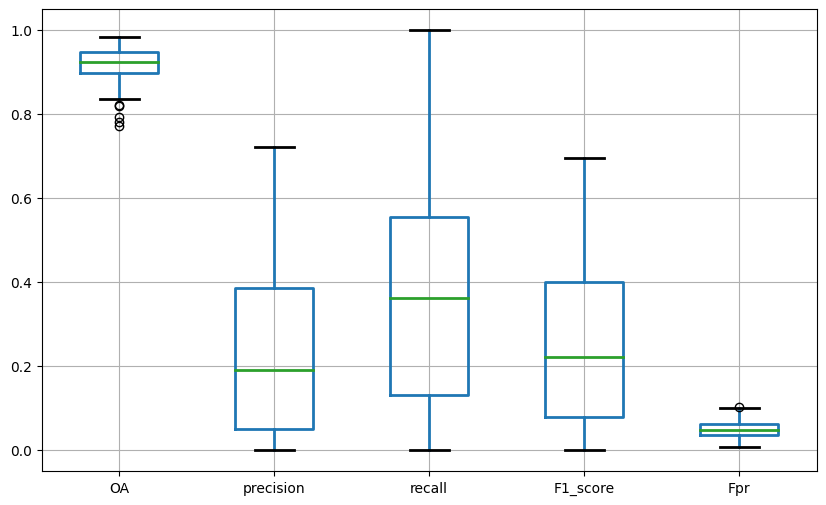

In [10]:
columns_to_plot = ['OA','precision','recall','F1_score','Fpr']
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
box = metric[columns_to_plot].boxplot( )
for box in box.artists:
    box.set_linewidth(2)

for whisker in box.lines:
    whisker.set_linewidth(2)
#plt.title('Boxplot of Metrices for LEVIR-CD dataset')
#plt.xlabel('Columns')
#plt.ylabel('Values')
plt.grid(True)
plt.savefig('boxplot_DSIFN-CD.pdf') #, bbox_inches='tight'
plt.show()
